<a href="https://colab.research.google.com/github/lele25811/Fruit-Classification/blob/main/Fruit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Classification - ResNet

In [ ]:
# Dataset: https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification

# 0. Import libraries

In [ ]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import random
import numpy as np
import pandas as pd

# 1. Download and setup the datasets

In [ ]:
# Create the destination directory
download_path = "/content/data/"
os.makedirs(download_path, exist_ok=True)

# Download the datasets in a specific directory
!kaggle datasets download -d utkarshsaxenadn/fruits-classification -p /content/data/

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification
License(s): CC0-1.0
 98% 83.0M/84.8M [00:04<00:00, 22.7MB/s]
100% 84.8M/84.8M [00:04<00:00, 18.6MB/s]


In [ ]:
import zipfile

# Path of zip
zip_file_path = os.path.join(download_path, "fruits-classification.zip")
extraction_path = os.path.join(download_path, "fruits")

# Unzip the datasets in a specific directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Datasets unzip in: {extraction_path}")

Datasets unzip in: /content/data/fruits


In [ ]:
# Train dataset path
dataset_path = "data/fruits/Fruits Classification/train"

# Classes of the datasets
classes_name = os.listdir(dataset_path)
print(f"Classes: {classes_name}")

Classes: ['Banana', 'Apple', 'Strawberry', 'Mango', 'Grape']


In [ ]:
# Paths of datasets
dataset_train_path = "/content/data/fruits/Fruits Classification/train"
dataset_test_path = "/content/data/fruits/Fruits Classification/test"

# Transformations for images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder(root=dataset_train_path, transform=transform)
test_dataset = ImageFolder(root=dataset_test_path, transform=transform)

print(f"Number of train images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of train images: 9700
Number of test images: 100


In [ ]:
# Create the dataloaders
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Train and test the model `ResNet18`

In [ ]:
# Load the model (ResNet18)
resnet18 = torchvision.models.resnet18(pretrained=True)

# Modify the last layer to adapt it to the number of classes in the dataset
num_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_features, len(train_dataset.classes))

# Move the model on device (cuda or cpu)
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet18 = resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.7MB/s]


In [ ]:
# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.001)

In [ ]:
# Train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
# Test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
# Train and Test function
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {
        "model_name": "ResNet18",
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=resnet18,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=resnet18,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Tran and Test the model
from timeit import default_timer as timer
start_time = timer()

epochs = 5

# Train model
resnet18_results = train(model=resnet18,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs)

# End the timer and print out how long it took
end_time = timer()
total_train_time_resnet18 = end_time-start_time
print(f"Total training time: {total_train_time_resnet18} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1641 | train_acc: 0.5606 | test_loss: 0.9964 | test_acc: 0.5938
Epoch: 2 | train_loss: 0.7237 | train_acc: 0.7604 | test_loss: 0.8660 | test_acc: 0.7031
Epoch: 3 | train_loss: 0.5859 | train_acc: 0.8028 | test_loss: 0.7086 | test_acc: 0.7266
Epoch: 4 | train_loss: 0.5018 | train_acc: 0.8289 | test_loss: 0.7219 | test_acc: 0.7422
Epoch: 5 | train_loss: 0.4543 | train_acc: 0.8429 | test_loss: 0.6263 | test_acc: 0.7422
Total training time: 128.05233140899998 seconds


In [ ]:
resnet18_results

{'model_name': 'ResNet18',
 'train_loss': [1.1641193718502396,
  0.723698246145719,
  0.5858923039938274,
  0.5017845051755246,
  0.4542587079401863],
 'train_acc': [0.5606496710526315,
  0.7603824013157895,
  0.8028371710526315,
  0.8289473684210527,
  0.8429276315789473],
 'test_loss': [0.9963943958282471,
  0.8659957051277161,
  0.7085913047194481,
  0.7219225391745567,
  0.6263343244791031],
 'test_acc': [0.59375, 0.703125, 0.7265625, 0.7421875, 0.7421875]}

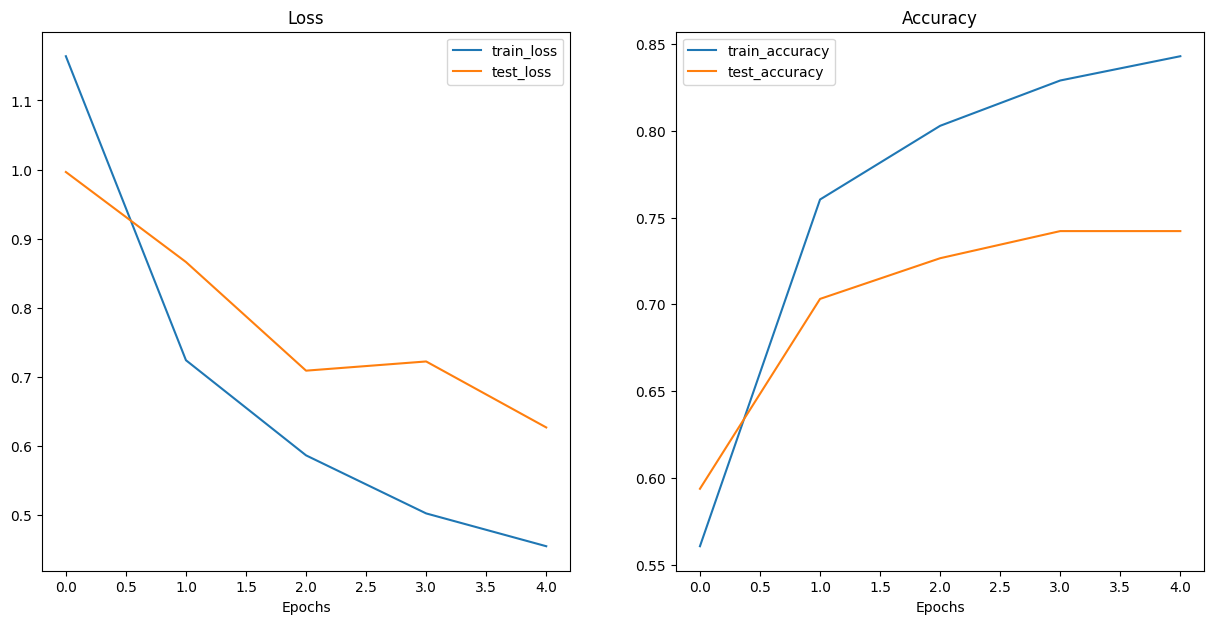

In [ ]:
# Plot the Loss and Accuracy curves

from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(resnet18_results)

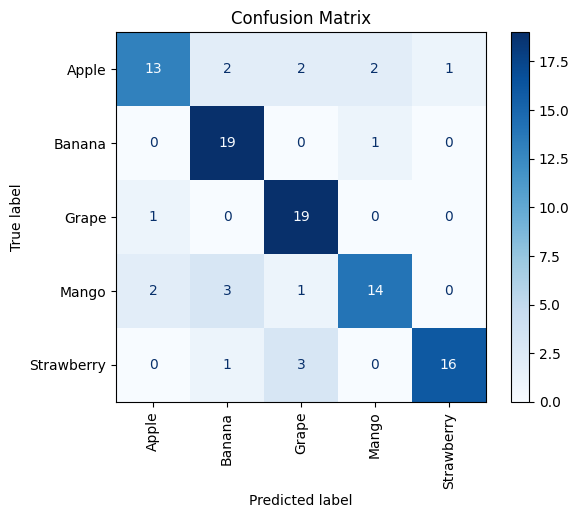

In [ ]:
# Confusion matrix function

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, classes=train_dataset.classes, device=device):

    # Put the model in eval mode
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation to speed up inference
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Take the class with the highest probability
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Show the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(resnet18, test_dataloader)

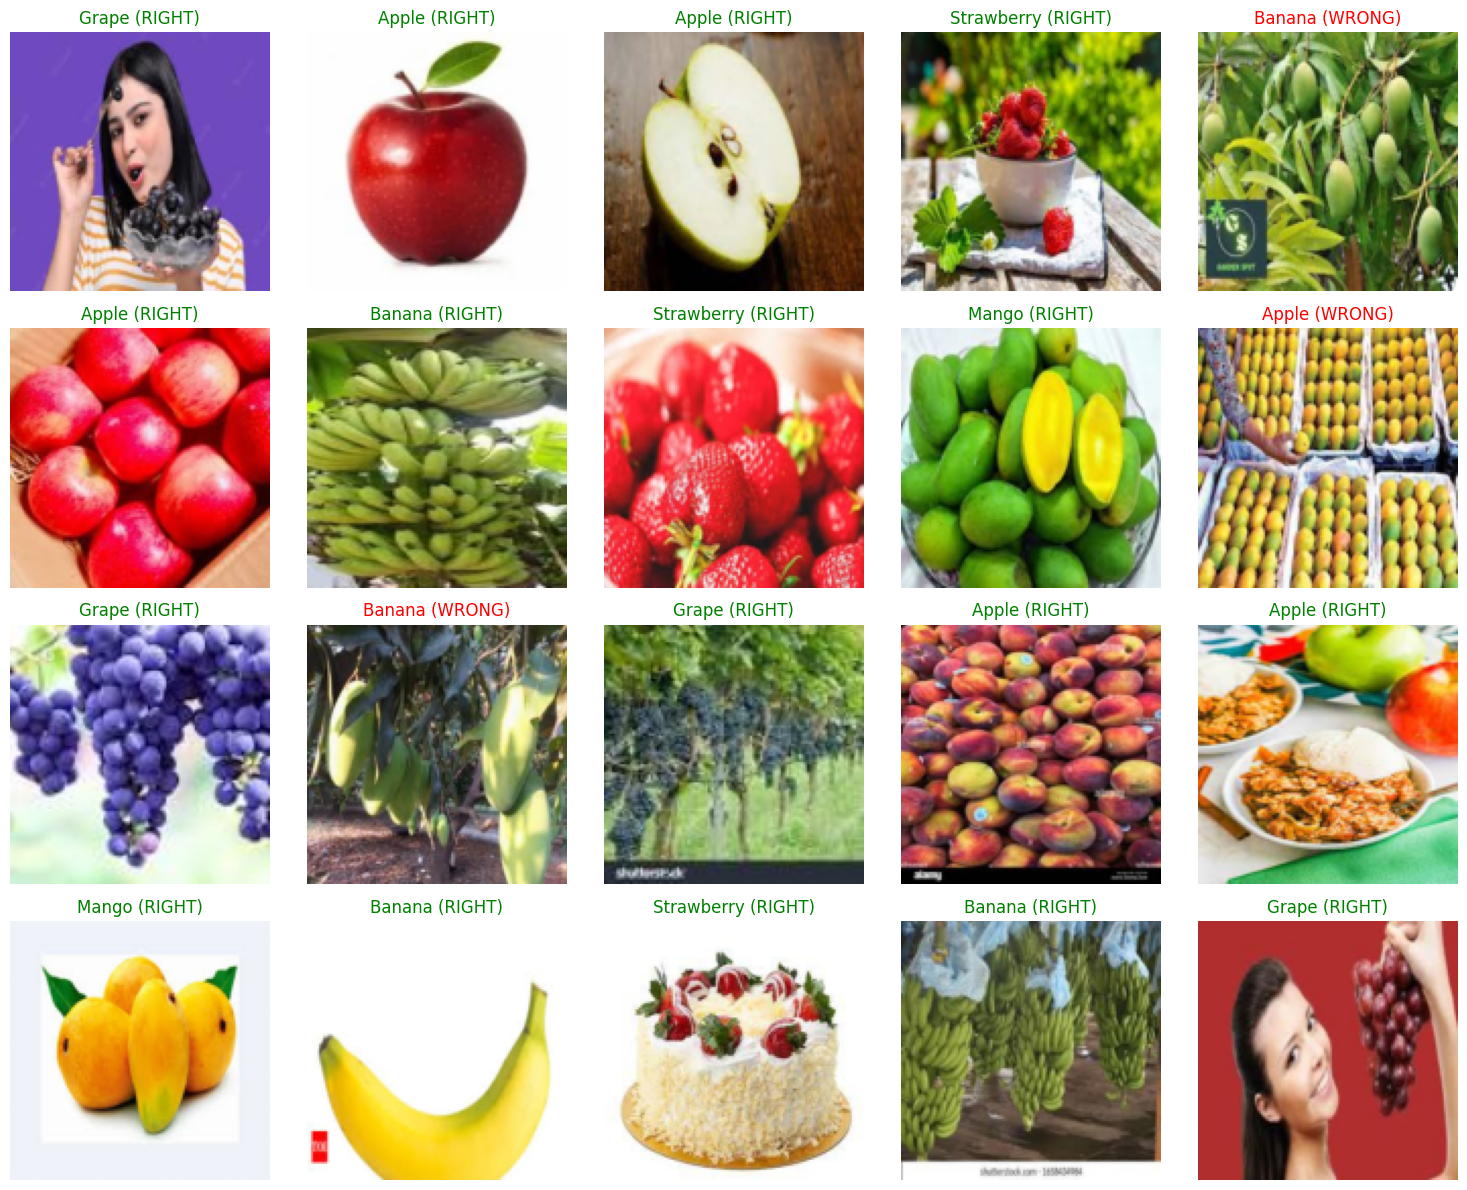

In [ ]:
# Show some images with the predictions

def images_with_pred(model, dataloader, device=device, num_images=20):

    # Put the model in eval mode
    model.eval()

    # Random selection of num_images images
    images = []
    labels = []
    for _ in range(num_images):
        idx = random.randint(0, len(dataloader.dataset) - 1)  # Select a random index
        image, label = dataloader.dataset[idx]  # Get image and label
        images.append(image)
        labels.append(label)

    images = torch.stack(images).to(device)  # Create a batch of images
    labels = torch.tensor(labels).to(device)  # Create a tensor of labels

    # Model predictions
    with torch.no_grad():
        output = model(images)  # Put the images in the model
        _, pred = torch.max(output, 1)  # Get the class with the highest probability

    # Show the images with the probability
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.ravel()

    for i in range(num_images):
        image = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert the image in HWC (heigth, weigth, color_channels) format
        image = np.clip(image, 0, 1)  # Clip (limit) the values between 0 and 1

        # Get the labels real and predicted
        label_corr = dataloader.dataset.classes[labels[i].item()]
        label_pred = dataloader.dataset.classes[pred[i].item()]

        axes[i].imshow(image)
        if label_corr == label_pred:
            axes[i].set_title(f"{label_pred} (RIGHT)", color='green')  # Title green: right
        else:
            axes[i].set_title(f"{label_pred} (WRONG)", color='red')  # Title red: wrong

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

images_with_pred(resnet18, test_dataloader)

# 3. Train and Test the model `ResNet50`

In [ ]:
# Load the model (ResNet50)
resnet50 = torchvision.models.resnet50(pretrained=True)

# Modify the last layer to adapt it to the number of classes in the dataset
num_features = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_features, len(train_dataset.classes))

# Move the model on device (cuda or cpu)
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet50 = resnet50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


In [ ]:
# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001)

In [ ]:
# Train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
# Test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
# Train and Test function
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {
        "model_name": "ResNet50",
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=resnet50,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=resnet50,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Train and Test the model
from timeit import default_timer as timer
start_time = timer()

epochs = 5

# Train model
resnet50_results = train(model=resnet50,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs)

# End the timer and print out how long it took
end_time = timer()
total_train_time_resnet50 = end_time-start_time
print(f"Total training time: {total_train_time_resnet50} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1183 | train_acc: 0.6320 | test_loss: 0.7759 | test_acc: 0.7266
Epoch: 2 | train_loss: 0.6499 | train_acc: 0.8025 | test_loss: 0.5598 | test_acc: 0.7734
Epoch: 3 | train_loss: 0.4831 | train_acc: 0.8461 | test_loss: 0.3994 | test_acc: 0.9141
Epoch: 4 | train_loss: 0.3970 | train_acc: 0.8702 | test_loss: 0.3607 | test_acc: 0.9297
Epoch: 5 | train_loss: 0.3322 | train_acc: 0.8943 | test_loss: 0.3318 | test_acc: 0.8672
Total training time: 214.17887372399997 seconds


In [ ]:
resnet50_results

{'model_name': 'ResNet50',
 'train_loss': [1.1182803429271047,
  0.6499081702020607,
  0.4831052096070428,
  0.3969895488239433,
  0.3322223600147194],
 'train_acc': [0.6319901315789473,
  0.8025287828947368,
  0.8461143092105263,
  0.8701685855263158,
  0.8943256578947368],
 'test_loss': [0.7759079784154892,
  0.5597665086388588,
  0.39939964562654495,
  0.36072563007473946,
  0.33182575553655624],
 'test_acc': [0.7265625, 0.7734375, 0.9140625, 0.9296875, 0.8671875]}

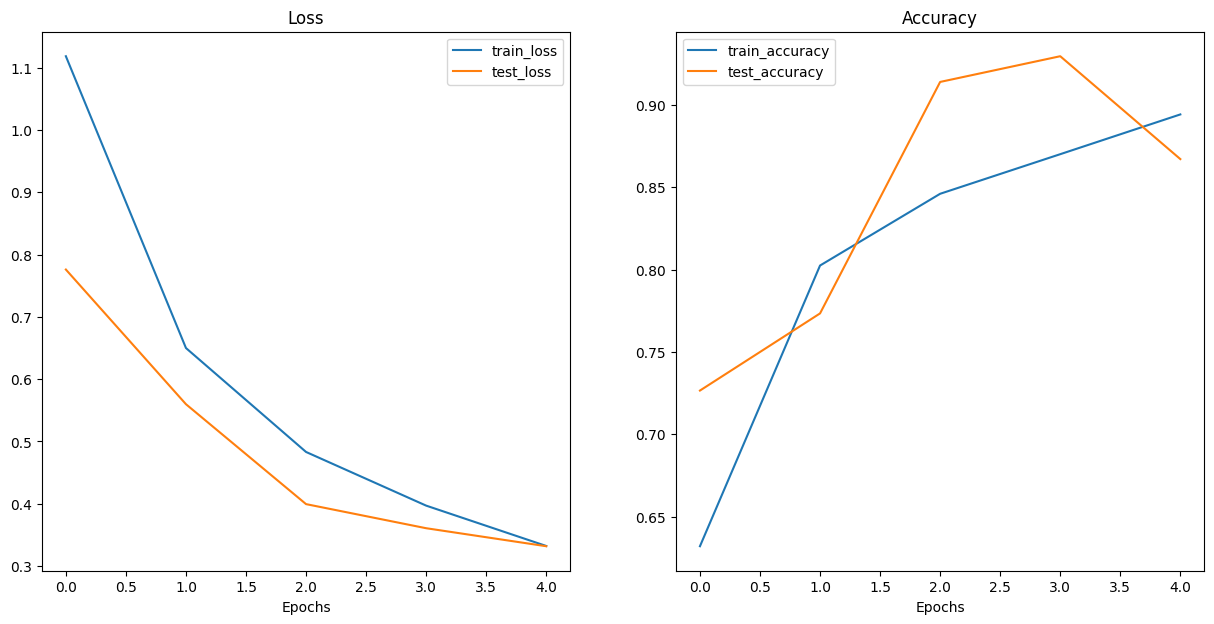

In [ ]:
# Plot the Loss and Accuracy curve

from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(resnet50_results)

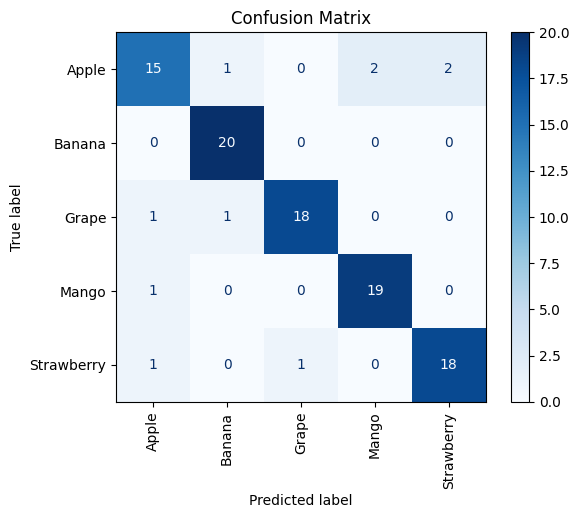

In [ ]:
# Confusion matrix function

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, classes=train_dataset.classes, device=device):

    # Put the model in eval mode
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation to speed up inference
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Take the class with the highest probability
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Show the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(resnet50, test_dataloader)

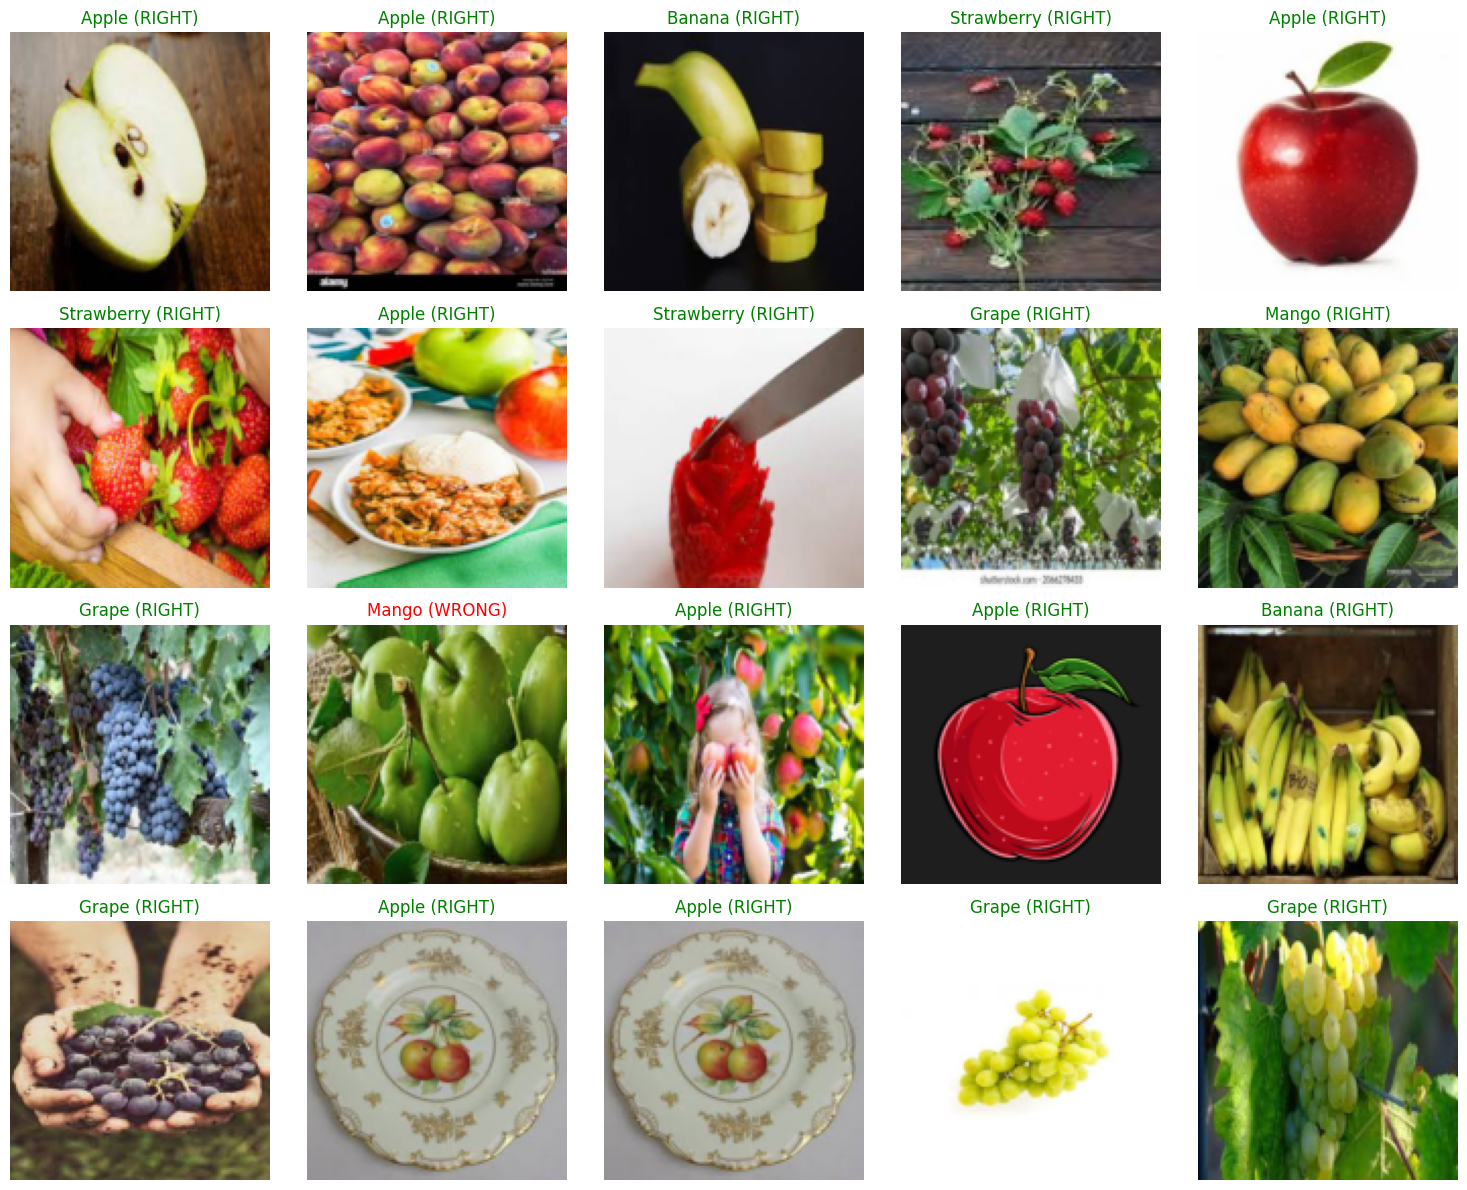

In [ ]:
# Show some images with the predictions

def images_with_pred(model, dataloader, device=device, num_images=20):

    # Put the model in eval mode
    model.eval()

    # Random selection of num_images images
    images = []
    labels = []
    for _ in range(num_images):
        idx = random.randint(0, len(dataloader.dataset) - 1)  # Select a random index
        image, label = dataloader.dataset[idx]  # Get image and label
        images.append(image)
        labels.append(label)

    images = torch.stack(images).to(device)  # Create a batch of images
    labels = torch.tensor(labels).to(device)  # Create a tensor of labels

    # Model predictions
    with torch.no_grad():
        output = model(images)  # Put the images in the model
        _, pred = torch.max(output, 1)  # Get the class with the highest probability

    # Show the images with the probability
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.ravel()

    for i in range(num_images):
        image = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert the image in HWC (heigth, weigth, color_channels) format
        image = np.clip(image, 0, 1)  # Clip (limit) the values between 0 and 1

        # Get the labels real and predicted
        label_corr = dataloader.dataset.classes[labels[i].item()]
        label_pred = dataloader.dataset.classes[pred[i].item()]

        axes[i].imshow(image)
        if label_corr == label_pred:
            axes[i].set_title(f"{label_pred} (RIGHT)", color='green')  # Title green: right
        else:
            axes[i].set_title(f"{label_pred} (WRONG)", color='red')  # Title red: wrong

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

images_with_pred(resnet50, test_dataloader)

# 4. `ResNet18` vs `ResNet50`
Compare Models results and training time

In [ ]:
models_results = pd.DataFrame([resnet18_results, resnet50_results])
models_results

model_name                                         train_loss  \
0   ResNet18  [1.1641193718502396, 0.723698246145719, 0.5858...   
1   ResNet50  [1.1182803429271047, 0.6499081702020607, 0.483...   

                                           train_acc  \
0  [0.5606496710526315, 0.7603824013157895, 0.802...   
1  [0.6319901315789473, 0.8025287828947368, 0.846...   

                                           test_loss  \
0  [0.9963943958282471, 0.8659957051277161, 0.708...   
1  [0.7759079784154892, 0.5597665086388588, 0.399...   

                                            test_acc  
0  [0.59375, 0.703125, 0.7265625, 0.7421875, 0.74...  
1  [0.7265625, 0.7734375, 0.9140625, 0.9296875, 0...

In [ ]:
# Add training times to results comparison
models_results["training_time"] = [total_train_time_resnet18,
                                    total_train_time_resnet50]
models_results

model_name                                         train_loss  \
0   ResNet18  [1.1641193718502396, 0.723698246145719, 0.5858...   
1   ResNet50  [1.1182803429271047, 0.6499081702020607, 0.483...   

                                           train_acc  \
0  [0.5606496710526315, 0.7603824013157895, 0.802...   
1  [0.6319901315789473, 0.8025287828947368, 0.846...   

                                           test_loss  \
0  [0.9963943958282471, 0.8659957051277161, 0.708...   
1  [0.7759079784154892, 0.5597665086388588, 0.399...   

                                            test_acc  training_time  
0  [0.59375, 0.703125, 0.7265625, 0.7421875, 0.74...     128.052331  
1  [0.7265625, 0.7734375, 0.9140625, 0.9296875, 0...     214.178874

Plottando i dati per il modello: ResNet18


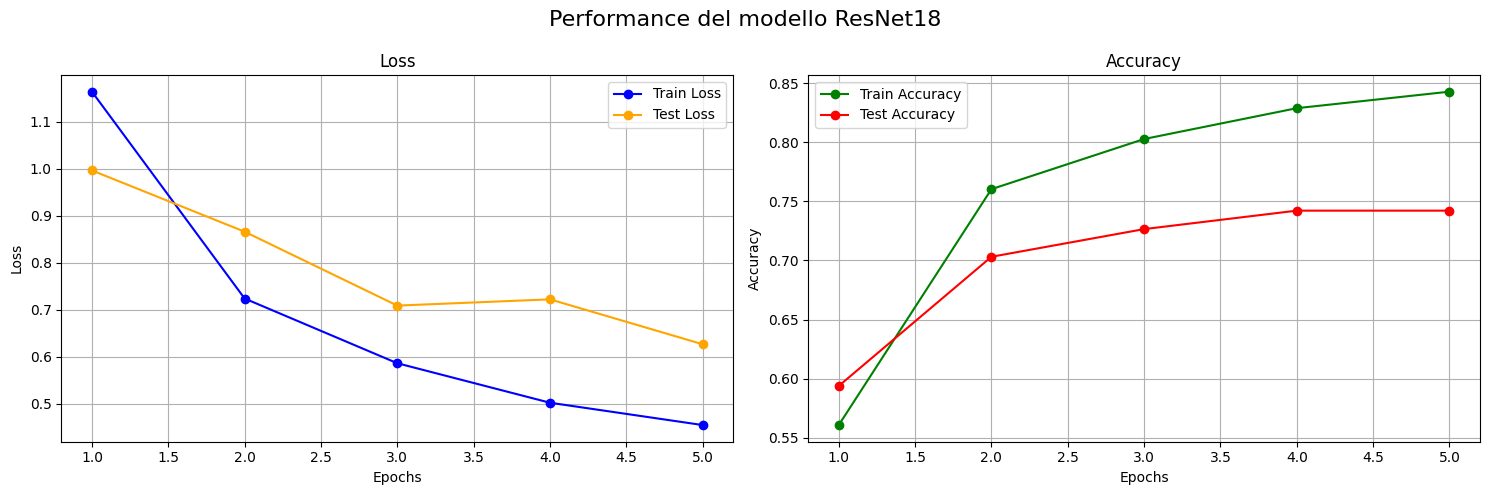

Plottando i dati per il modello: ResNet50


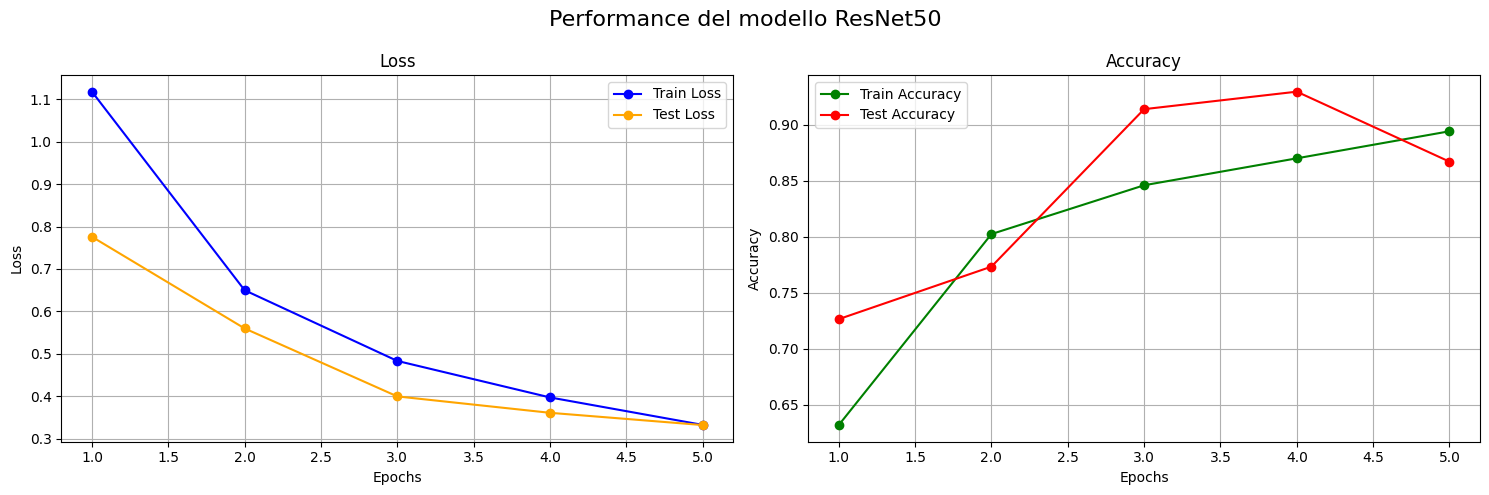

In [ ]:
def plot_results_from_dataframe(model_results):

    # Iterate over models in the dataframe
    for index, row in model_results.iterrows():
        model_name = row['model_name']
        train_loss = row['train_loss']
        train_acc = row['train_acc']
        test_loss = row['test_loss']
        test_acc = row['test_acc']
        epochs = range(1, len(train_loss) + 1)

        print(f"Plottando i dati per il modello: {model_name}")

        # Plot the results
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f"Performance del modello {model_name}", fontsize=16)

        # Loss Plot
        axs[0].plot(epochs, train_loss, label='Train Loss', color='blue', marker='o')
        axs[0].plot(epochs, test_loss, label='Test Loss', color='orange', marker='o')
        axs[0].set_title('Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid(True)

        # Accuracy Plot
        axs[1].plot(epochs, train_acc, label='Train Accuracy', color='green', marker='o')
        axs[1].plot(epochs, test_acc, label='Test Accuracy', color='red', marker='o')
        axs[1].set_title('Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        axs[1].grid(True)

        # Show the graphs
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

plot_results_from_dataframe(models_results)

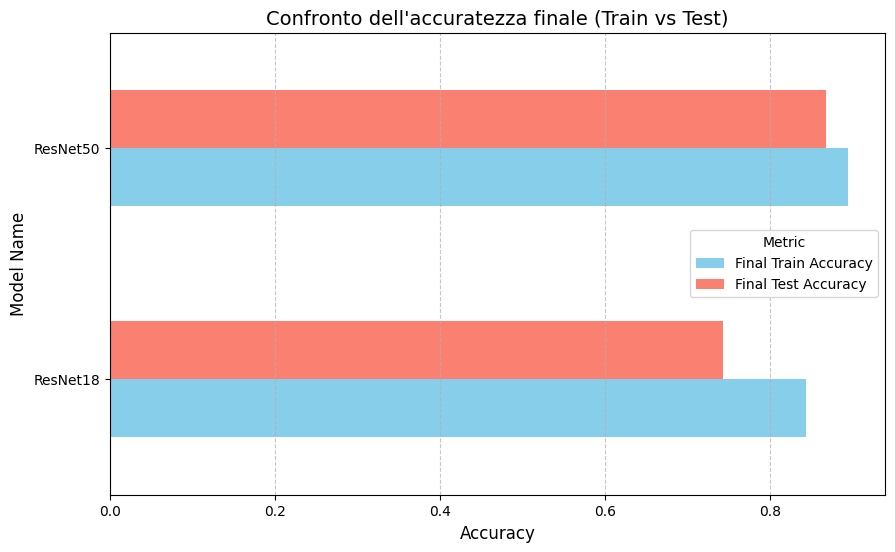

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_model_accuracy(model_results):

    # Extract model names and final accuracy
    accuracy_data = {
        "Model Name": model_results["model_name"],
        "Final Train Accuracy": [res["train_acc"][-1] for res in model_results.to_dict(orient="records")],
        "Final Test Accuracy": [res["test_acc"][-1] for res in model_results.to_dict(orient="records")],
    }

    # Create a DateFrame for the accuracy
    accuracy_df = pd.DataFrame(accuracy_data).set_index("Model Name")

    # Plot a Horizontal bar
    accuracy_df.plot(kind="barh", figsize=(10, 6), color=["skyblue", "salmon"])
    plt.title("Confronto dell'accuratezza finale (Train vs Test)", fontsize=14)
    plt.xlabel("Accuracy", fontsize=12)
    plt.ylabel("Model Name", fontsize=12)
    plt.legend(title="Metric", fontsize=10)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

compare_model_accuracy(models_results)